![Photo by Stephen Phillips - Hostreviews.co.uk on UnSplash](https://cf.bstatic.com/xdata/images/hotel/max1024x768/408003083.jpg?k=c49b5c4a2346b3ab002b9d1b22dbfb596cee523b53abef2550d0c92d0faf2d8b&o=&hp=1){fig-align="center" width=50%}


# Import data

In [22]:
import gc
from pathlib import Path
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt


import catboost
import numpy as np
import pandas as pd
import shap
from IPython.display import clear_output
from lets_plot import *
from lets_plot.mapping import as_discrete
from sklearn import ensemble, impute, metrics, model_selection
from tqdm import tqdm

from data import pre_process, utils
from models import train_model

LetsPlot.setup_html()

**Objective**:


1. **Cross-validation**: Implement a robust cross-validation strategy to assess our model's performance accurately and consistently across multiple folds of the data.
2. **Outlier Identification**: Identify and scrutinize potential outliers within our dataset. This step is crucial to ensure that outliers don't unduly influence our model's predictions.
3. **Feature Engineering**: Continue refining and expanding our feature engineering efforts. We'll explore new ways to create informative features that enhance our model's predictive capabilities.



# Prepare dataframe before modelling
## Read in dataframe


In [2]:
df = pd.read_parquet(
    utils.Configuration.INTERIM_DATA_PATH.joinpath(
        "2023-10-01_Processed_dataset_for_NB_use.parquet.gzip"
    )
)

In [3]:
def prepare_data_for_modelling(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepare data for machine learning modeling.

    This function takes a DataFrame and prepares it for machine learning by performing the following steps:
    1. Randomly shuffles the rows of the DataFrame.
    2. Converts the 'price' column to the base 10 logarithm.
    3. Fills missing values in categorical variables with 'missing value'.
    4. Separates the features (X) and the target (y).

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series]: A tuple containing the prepared features (X) and the target (y).

    Example use case:
    ```python
    # Load your dataset into a DataFrame (e.g., df)
    df = load_data()

    # Prepare the data for modeling
    X, y = prepare_data_for_modelling(df)

    # Now you can use X and y for machine learning tasks.
    ```
    """

    processed_df = (
        df.sample(frac=1, random_state=utils.Configuration.seed)
        .reset_index(drop=True)
        .assign(price=lambda df: np.log10(df.price))
    )

    # Fill missing categorical variables with "missing value"
    for col in processed_df.columns:
        if processed_df[col].dtype.name in ("bool", "object", "category"):
            processed_df[col] = processed_df[col].fillna("missing value")

    # Separate features (X) and target (y)
    X = processed_df.loc[:, utils.Configuration.features_to_keep]
    y = processed_df[utils.Configuration.target_col]

    print(f"Shape of X and y: {X.shape}, {y.shape}")

    return X, y

In [4]:
X, y = pre_process.prepare_data_for_modelling(df)

Shape of X and y: (3660, 16), (3660,)


# Cross-validation

In [5]:
def run_catboost_CV(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 2,
    n_repeats: int = 1,
    pipeline: Optional[object] = None,
) -> Tuple[float, float]:
    """
    Perform Cross-Validation with CatBoost for regression.

    This function conducts Cross-Validation using CatBoost for regression tasks. It iterates
    through folds, trains CatBoost models, and computes the mean and standard deviation of the
    Root Mean Squared Error (RMSE) scores across folds.

    Parameters:
    - X (pd.DataFrame): The feature matrix.
    - y (pd.Series): The target variable.
    - n_splits (int, optional): The number of splits in K-Fold cross-validation.
      Defaults to 2.
    - n_repeats (int, optional): The number of times the K-Fold cross-validation is repeated.
      Defaults to 1.
    - pipeline (object, optional): Optional data preprocessing pipeline. If provided,
      it's applied to the data before training the model. Defaults to None.

    Returns:
    - Tuple[float, float]: A tuple containing the mean RMSE and standard deviation of RMSE
      scores across cross-validation folds.

    Example:
    ```python
    # Load your feature matrix (X) and target variable (y)
    X, y = load_data()

    # Perform Cross-Validation with CatBoost
    mean_rmse, std_rmse = run_catboost_CV(X, y, n_splits=5, n_repeats=2, pipeline=data_pipeline)

    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
    ```

    Notes:
    - Ensure that the input data `X` and `y` are properly preprocessed and do not contain any
      missing values.
    - The function uses CatBoost for regression with optional data preprocessing via the `pipeline`.
    - RMSE is a common metric for regression tasks, and lower values indicate better model
      performance.
    """
    results = []

    # Extract feature names and data types
    features = X.columns[~X.columns.str.contains("price")]
    numerical_features = X.select_dtypes("number").columns.to_list()
    categorical_features = X.select_dtypes("object").columns.to_list()

    # Create a K-Fold cross-validator
    CV = model_selection.RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=utils.Configuration.seed
    )

    for train_fold_index, val_fold_index in tqdm(CV.split(X)):
        X_train_fold, X_val_fold = X.loc[train_fold_index], X.loc[val_fold_index]
        y_train_fold, y_val_fold = y.loc[train_fold_index], y.loc[val_fold_index]

        # Apply optional data preprocessing pipeline
        if pipeline is not None:
            X_train_fold = pipeline.fit_transform(X_train_fold)
            X_val_fold = pipeline.transform(X_val_fold)

        # Create CatBoost datasets
        catboost_train = Pool(
            X_train_fold,
            y_train_fold,
            cat_features=categorical_features,
        )
        catboost_valid = Pool(
            X_val_fold,
            y_val_fold,
            cat_features=categorical_features,
        )

        # Initialize and train the CatBoost model
        model = catboost.CatBoostRegressor(**utils.Configuration.catboost_params)
        model.fit(
            catboost_train,
            eval_set=[catboost_valid],
            early_stopping_rounds=utils.Configuration.early_stopping_round,
            verbose=utils.Configuration.verbose,
            use_best_model=True,
        )

        # Calculate OOF validation predictions
        valid_pred = model.predict(X_val_fold)

        RMSE_score = metrics.mean_squared_error(y_val_fold, valid_pred, squared=False)

        results.append(RMSE_score)

    return np.mean(results), np.std(results)


::: {.callout-note}Please note that we reduced the number of iterations here in comparison to Notebook 4, in order to reduce the training time.:NB4 :  iterations = 1000, learning rate = default == 0.03
NB5 : iterations = 100, learning rate = 0.2
`.
:::

In [6]:
train_model.run_catboost_CV(X, y)

10it [00:49,  4.93s/it]


(0.11264123385419991, 0.005418341119823515)

 * 0.05 = 0.1266
 * 0.1 = 0.1177
 * 0.15 = 0.1139
 * 0.2 = 0.1125
 * 0.25 = 0.1126

# Isolation forest

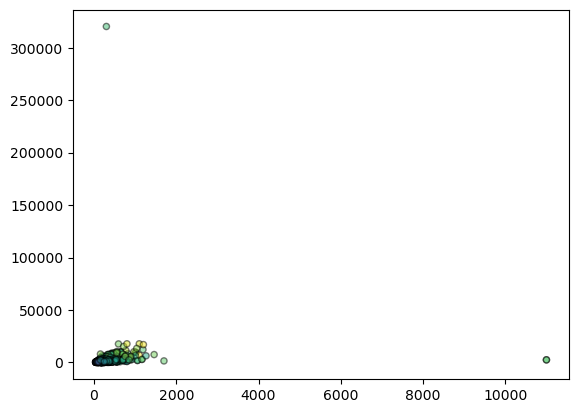

In [48]:
import matplotlib.pyplot as plt

plt.scatter(
    X.loc[:, "living_area"], X.loc[:, "cadastral_income"], c=y, s=20, edgecolor="k", alpha=0.5
)

In [49]:
X_numeric = X.select_dtypes("number")

imputer = impute.SimpleImputer(missing_values=np.nan, strategy="median").set_output(
    transform="pandas"
)
X_numeric = imputer.fit_transform(X_numeric)

clf = ensemble.IsolationForest(max_samples=100, random_state=0)
clf.fit(X_numeric)

IsolationForest(max_samples=100, random_state=0)

In [50]:
y_pred = clf.predict(X_numeric)
y_pred_adjusted = [1 if x == -1 else 0 for x in y_pred]
sum(y_pred_adjusted)

381

# Feature Engineering

**SOME IDEAS**

1. **Categorical Features:**
   - Encode categorical variables like "state," "kitchen_type," "building_condition," and "city" using one-hot encoding or label encoding.

2. **Geospatial Features:**
   - Calculate the distance from each apartment to key locations in the city (e.g., city center, schools, parks, public transportation) using "lat" and "lng."
   - Create clusters or neighborhoods based on the latitude and longitude coordinates (lat, lng) to capture the regional effect on prices.

3. **Spatial Features:**
   - Explore the "number_of_frontages" and how it affects property prices. You could categorize this variable or use it as a numerical feature.

4. **Area-related Features:**
   - Calculate the ratio of "living_area" to "surface_of_the_plot" to get an idea of the density or spaciousness of the property.
   - Create bins or categories for "living_area" and "surface_of_the_plot" to capture different property sizes.

5. **Energy Efficiency Features:**
   - Compute the energy efficiency ratio by dividing "yearly_theoretical_total_energy_consumption" by "primary_energy_consumption."
   - Normalize energy-related features to have a similar scale if they are measured in different units.

6. **Toilet and Bathroom Features:**
   - Combine "toilets" and "bathrooms" into a single "total_bathrooms" feature to simplify the model.

7. **Parking Features:**
   - If parking information is available, create binary features indicating the presence of covered or uncovered parking spaces.

8. **Taxation Features:**
   - Incorporate "cadastral_income" as a measure of property value for taxation. You can create bins or categories for this variable.

9. **Combining Features:**
   - Experiment with interactions and products of different features to capture complex relationships. For instance, you could multiply "living_area" by "cadastral_income" to get a new feature.
  
10. 
TODO : 

Feature engineering:
- use EJ categorical column for groupby/transform
- create bins from continous data and groupby/transform : sklearn.preprocessing.KBinsDiscretizer
- create column that has flags where missing values present : sklearn.impute.MissingIndicator
- interons
'''
